# Forward Retreating - Mid-Field and Defense Advancing- Strategy

## Strategy Description

In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

In [2]:
import datetime  # For datetime objects
import sys  # To find out the script name (in argv[0])

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
import pyfolio as pf

In [15]:
import backtrader as bt

In [25]:
cerebro = bt.Cerebro()

In [26]:
data = bt.feeds.GenericCSVData(
    dataname='result.csv',

    fromdate=datetime.datetime(2018, 1, 16, 22, 40),
    todate=datetime.datetime(2018, 4, 21, 2, 50),
    timeframe = bt.TimeFrame.Minutes,

    nullvalue=0.0,

    dtformat=('%Y-%m-%d %H:%M:%S'),

    datetime=4,
    high=76,
    low=77,
    open=75,
    close=78,
    volume=79,
    openinterest=-1
)

In [27]:
# Add the Data Feed to Cerebro
cerebro.adddata(data)

In [28]:
# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('exitbars', 5),
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime[0]
        dt = bt.num2date(dt)
        print('%s, %s' % (dt, txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        self.datahigh = self.datas[0].high
        self.datalow = self.datas[0].low
               

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None


    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enougth cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:
            
            #Not yet...we MIGHT Long if....
            self.enter_long(self)
            
            #Not yet...we MIGHT Short if....
            self.enter_short(self)

                

        else:

            # Already in the market ... we might exit
            
            #Exit from Long Position
            if self.position.size > 0:
                self.exit_long(self)
                
  
            #Exit from Short position
            if self.position.size < 0:
                self.exit_short(self)
                

                              

    def enter_long(self, next):
        
        #We MIGHT BUY if....
        if self.dataclose[0] > self.dataclose[-1]:
            # current close is higher than previous close
                
            if self.datahigh[0] < self.datahigh[-1] and self.datalow[0] > self.datalow[-1]:
                #current high is lower than previous high and current low is higher than previous low
                    
                if self.dataclose[-1] > self.dataclose[-2]:
                    #previous close is higher than the close before that
                        
                    #BUY, BUY, BUY!!! (with all possible default parameters)
                    self.log('BUY CREATE, %.2f' % self.dataclose[0])
                        
                    #Keep track of the created order to avoid a 2nd order
                    self.order = self.buy()

    def enter_short(self, next):
        
        #We MIGHT Sell if....
        if self.dataclose[0] < self.dataclose[-1]:
            # current close is less than previous close
                
            if self.datahigh[0] < self.datahigh[-1] and self.datalow[0] > self.datalow[-1]:
                #current high is lower than previous high and current low is higher than previous low
                    
                if self.dataclose[-1] < self.dataclose[-2]:
                    #previous close is lower than the close before that
                        
                    #BUY, BUY, BUY!!! (with all possible default parameters)
                    self.log('Short Sell CREATE, %.2f' % self.dataclose[0])
                        
                    #Keep track of the created order to avoid a 2nd order
                    self.order = self.sell()
                    
                        
    def exit_long(self,next):
        #Exit from Long Position
        if self.position.size > 0:
                
            if len(self) >= (self.bar_executed + self.params.exitbars):
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()
                
                
    def exit_short(self,next):
        #Exit from Short position
        if self.position.size < 0:
                
            if len(self) >= (self.bar_executed + self.params.exitbars):
                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('COVER Short CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()
        
        
        

In [29]:
# Add a strategy
cerebro.addstrategy(TestStrategy)


0

In [30]:
# Set the commission - 0.1% ... divide by 100 to remove the %
cerebro.broker.setcommission(commission=0.001)

In [31]:
# Add a FixedSize sizer according to the stake
cerebro.addsizer(bt.sizers.FixedSize, stake=10)

In [32]:
#Basic TradeStats Analyzer
cerebro.addanalyzer(bt.analyzers.BasicTradeStats, filter='all', _name ='all')   # Default..  
cerebro.addanalyzer(bt.analyzers.BasicTradeStats, filter='short')
cerebro.addanalyzer(bt.analyzers.BasicTradeStats, filter='long')

cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

Entire data start date: 2018-01-16
Entire data end date: 2018-04-21
Backtest months: 3


,Backtest
Annual return,-1.3%
Cumulative returns,-0.4%
Annual volatility,0.2%
Sharpe ratio,-7.08
Calmar ratio,-3.13
Stability,0.95
Max drawdown,-0.4%
Omega ratio,0.13
Sortino ratio,-6.65
Skew,-2.22


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,0.40,2018-01-16,2018-04-19,NaT,NaN
1,0.00,2018-01-16,2018-01-16,2018-01-16,1
2,0.00,2018-01-16,2018-01-16,2018-01-16,1
3,0.00,2018-01-16,2018-01-16,2018-01-16,1
4,0.00,2018-01-16,2018-01-16,2018-01-16,1


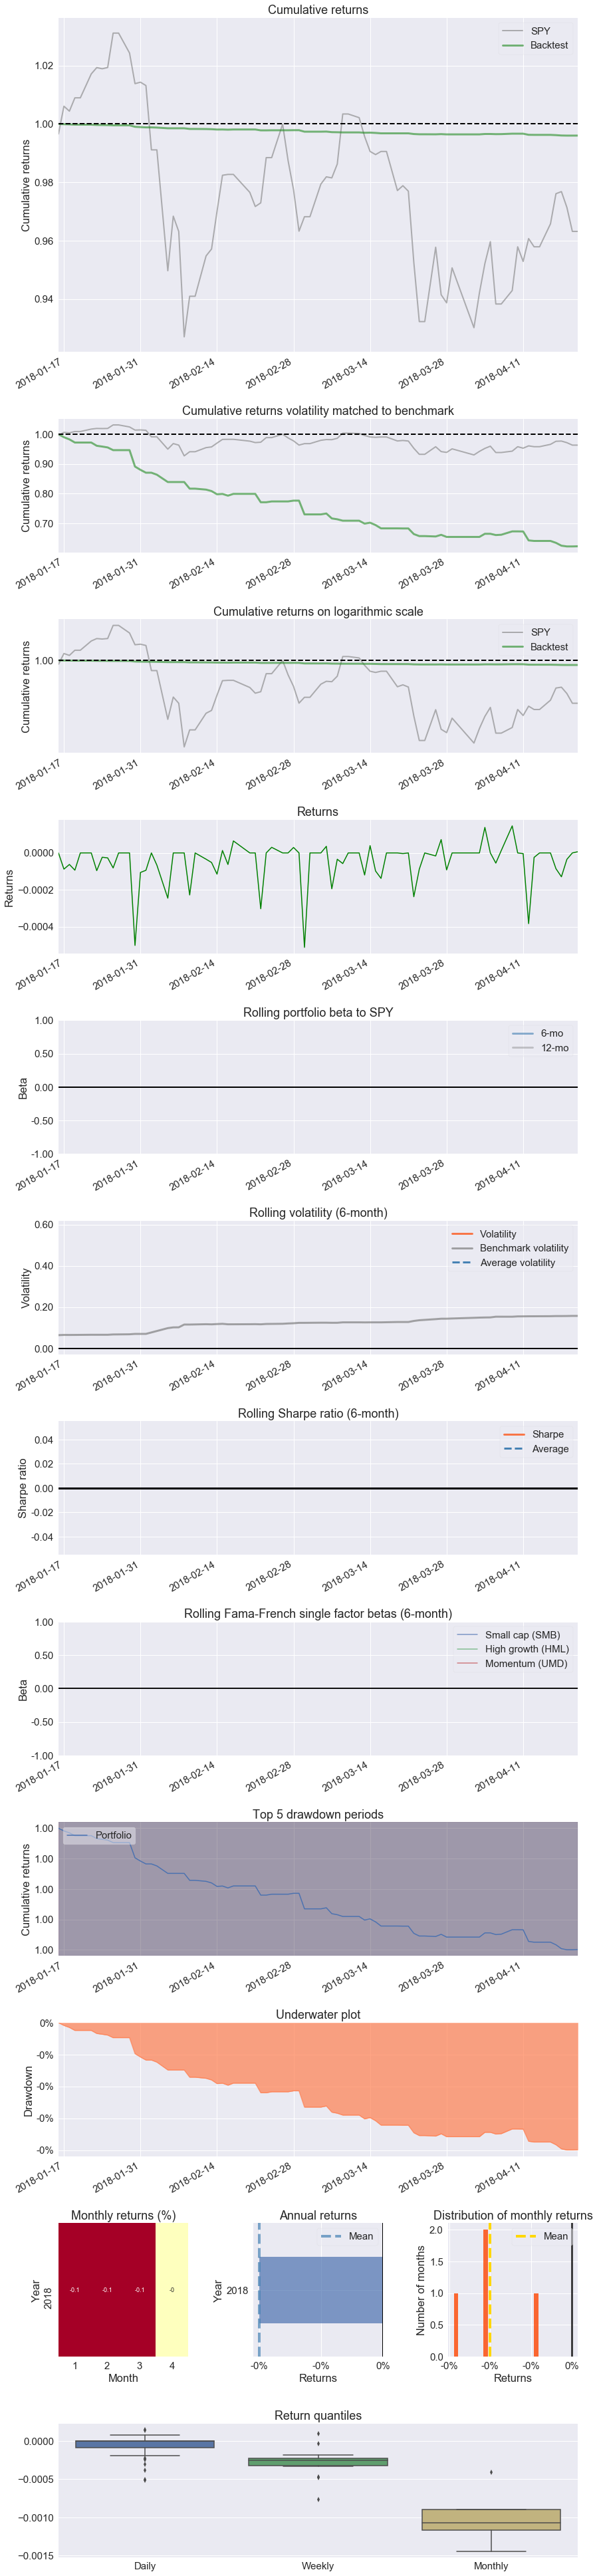

Stress Events,mean,min,max
New Normal,-0.00%,-0.05%,0.01%


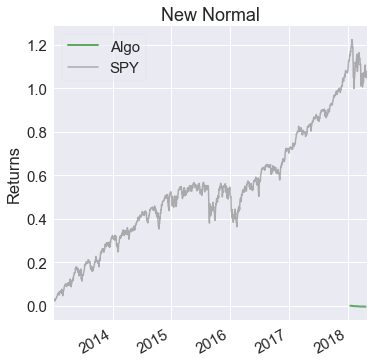

Top 10 long positions of all time,max
result,2.86%


Top 10 short positions of all time,max
result,-2.87%


Top 10 positions of all time,max
result,2.87%


All positions ever held,max
result,2.87%


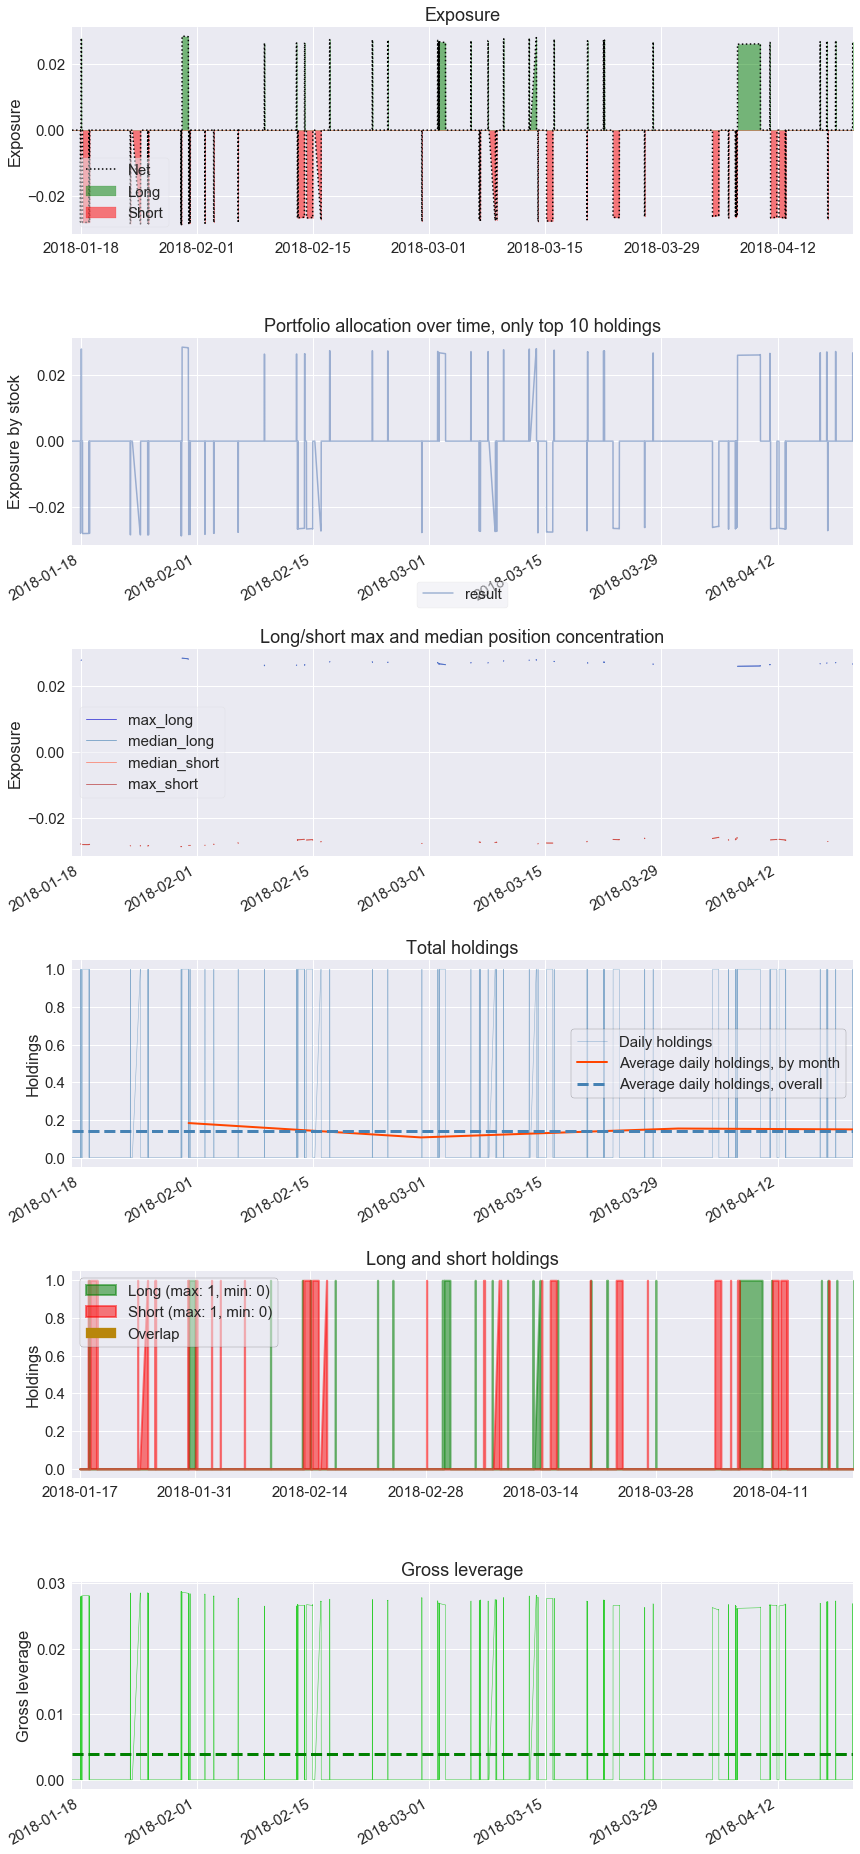

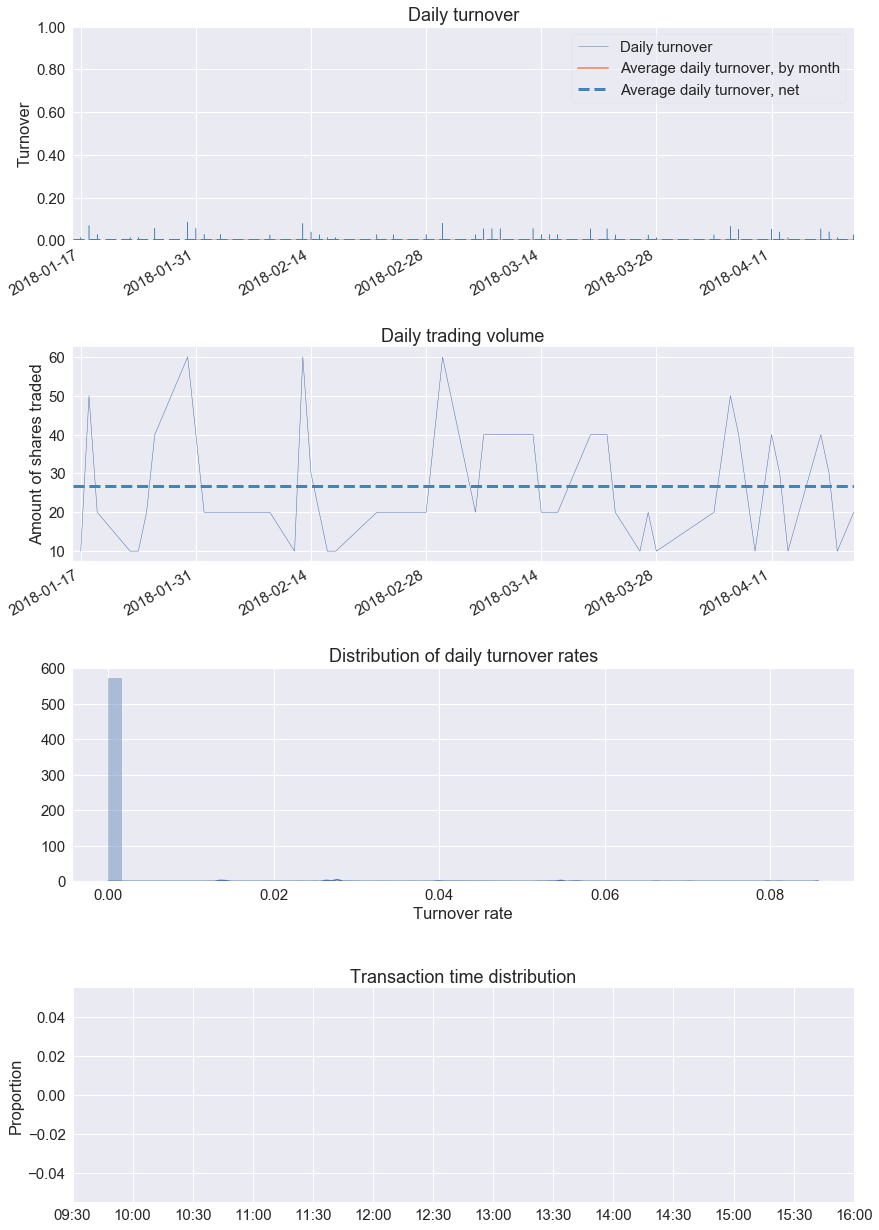

In [40]:
pf.create_full_tear_sheet(
            returns,
            positions= positions,
            transactions=transactions,
            round_trips=False)

In [33]:
# Set our desired cash start
cerebro.broker.setcash(1000000.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
# Run strategy and return a list of strategies - only have one strategy in this example
strats = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2018-01-16 22:40:00, Close, 2809.75
2018-01-16 22:50:00, Close, 2810.50
2018-01-16 22:50:00, Close, 2810.50
2018-01-16 23:00:00, Close, 2808.50
2018-01-16 23:00:00, Close, 2808.50
2018-01-16 23:10:00, Close, 2809.75
2018-01-16 23:10:00, Close, 2809.75
2018-01-16 23:20:00, Close, 2806.75
2018-01-16 23:20:00, Close, 2806.75
2018-01-16 23:30:00, Close, 2800.25
2018-01-16 23:30:00, Close, 2800.25
2018-01-16 23:40:00, Close, 2802.75
2018-01-16 23:40:00, Close, 2802.75
2018-01-16 23:50:00, Close, 2798.50
2018-01-16 23:50:00, Close, 2798.50
2018-01-17 00:00:00, Close, 2796.00
2018-01-17 00:00:00, Close, 2796.00
2018-01-17 00:10:00, Close, 2797.75
2018-01-17 00:20:00, Close, 2800.00
2018-01-17 00:30:00, Close, 2800.75
2018-01-17 00:40:00, Close, 2797.25
2018-01-17 00:50:00, Close, 2795.75
2018-01-17 01:00:00, Close, 2797.00
2018-01-17 01:10:00, Close, 2799.75
2018-01-17 01:20:00, Close, 2797.25
2018-01-17 01:30:00, Close, 2796.00
2018-01-17 01:40:00, Close,

2018-02-03 04:30:00, Close, 2775.75
2018-02-03 04:40:00, Close, 2768.00
2018-02-03 04:50:00, Close, 2764.75
2018-02-03 05:00:00, Close, 2764.50
2018-02-03 05:10:00, Close, 2760.75
2018-02-05 22:30:00, Close, 2745.50
2018-02-05 22:40:00, Close, 2744.75
2018-02-05 22:40:00, Short Sell CREATE, 2744.75
2018-02-05 22:50:00, SELL EXECUTED, Price: 2744.50, Cost: -27445.00, Comm 27.45
2018-02-05 22:50:00, Close, 2749.00
2018-02-05 23:00:00, Close, 2753.75
2018-02-05 23:10:00, Close, 2758.75
2018-02-05 23:20:00, Close, 2765.50
2018-02-05 23:30:00, Close, 2758.50
2018-02-05 23:40:00, Close, 2765.00
2018-02-05 23:40:00, COVER Short CREATE, 2765.00
2018-02-05 23:50:00, BUY EXECUTED, Price: 2763.50, Cost: -27445.00, Comm 27.64
2018-02-05 23:50:00, OPERATION PROFIT, GROSS -190.00, NET -245.08
2018-02-05 23:50:00, Close, 2763.00
2018-02-06 00:00:00, Close, 2760.75
2018-02-06 00:10:00, Close, 2759.00
2018-02-06 00:20:00, Close, 2757.00
2018-02-06 00:30:00, Close, 2753.75
2018-02-06 00:40:00, Close, 27

2018-03-15 01:50:00, Close, 2763.75
2018-03-15 02:00:00, Close, 2763.75
2018-03-15 02:10:00, Close, 2758.50
2018-03-15 02:20:00, Close, 2759.75
2018-03-15 02:30:00, Close, 2754.00
2018-03-15 02:40:00, Close, 2754.00
2018-03-15 02:50:00, Close, 2756.75
2018-03-15 03:00:00, Close, 2753.50
2018-03-15 03:10:00, Close, 2752.25
2018-03-15 03:20:00, Close, 2750.75
2018-03-15 03:20:00, Short Sell CREATE, 2750.75
2018-03-15 03:30:00, SELL EXECUTED, Price: 2751.00, Cost: -27510.00, Comm 27.51
2018-03-15 03:30:00, Close, 2751.25
2018-03-15 03:40:00, Close, 2754.75
2018-03-15 03:50:00, Close, 2754.50
2018-03-15 04:00:00, Close, 2754.00
2018-03-15 04:10:00, Close, 2754.00
2018-03-15 21:30:00, Close, 2755.25
2018-03-15 21:30:00, COVER Short CREATE, 2755.25
2018-03-15 21:40:00, BUY EXECUTED, Price: 2755.25, Cost: -27510.00, Comm 27.55
2018-03-15 21:40:00, OPERATION PROFIT, GROSS -42.50, NET -97.56
2018-03-15 21:40:00, Close, 2752.25
2018-03-15 21:50:00, Close, 2753.75
2018-03-15 22:00:00, Close, 2758

In [34]:
# Get our strategy returned from cerebro.run() and display output
strat0 = strats[0]


for each in strat0.analyzers:
    each.print()

╔══════════════════╦═══════════╗  ╔═════════════════╦═══════════╦════════════╗
║                  ║ALL TRADES ║  ║                 ║TRADES WON ║TRADES LOST ║
╠══════════════════╬═══════════╣  ╠═════════════════╬═══════════╬════════════╣
║TRADES       open ║0          ║  ║TRADES           ║           ║            ║
║           closed ║64         ║  ║          closed ║18         ║46          ║
║       Win Factor ║0.39       ║  ║               % ║28.12      ║71.88       ║
╠══════════════════╬═══════════╣  ╠═════════════════╬═══════════╬════════════╣
║PROFIT      total ║-3987.7625 ║  ║PROFIT     total ║850.3325   ║-4838.0950  ║
║          average ║-62.3088   ║  ║         average ║47.2407    ║-105.1760   ║
║    Profit Factor ║0.18       ║  ║          median ║37.6725    ║-85.6375    ║
║    Reward : Risk ║0.45       ║  ║             max ║138.0400   ║-391.8450   ║
╠══════════════════╬═══════════╣  ╠═════════════════╬═══════════╬════════════╣
║STREAK    Z-Score ║-3.87      ║  ║STREAK   current 

    - 2018-04-20 02:10:00: 0.0, 996005.6575
    - 2018-04-20 02:20:00: 0.0, 996005.6575
    - 2018-04-20 02:30:00: 0.0, 996005.6575
    - 2018-04-20 02:40:00: 0.0, 996005.6575
    - 2018-04-20 02:50:00: 0.0, 996005.6575
    - 2018-04-20 03:00:00: 0.0, 996005.6575
    - 2018-04-20 03:10:00: 0.0, 996005.6575
    - 2018-04-20 03:20:00: 0.0, 996005.6575
    - 2018-04-20 03:30:00: 0.0, 996005.6575
    - 2018-04-20 03:40:00: 0.0, 996005.6575
    - 2018-04-20 03:50:00: 0.0, 996005.6575
    - 2018-04-20 04:00:00: 0.0, 996005.6575
    - 2018-04-20 04:10:00: 0.0, 996005.6575
    - 2018-04-20 21:30:00: 0.0, 996005.6575
    - 2018-04-20 21:40:00: 0.0, 996005.6575
    - 2018-04-20 21:50:00: 0.0, 996005.6575
    - 2018-04-20 22:00:00: 0.0, 996005.6575
    - 2018-04-20 22:10:00: 0.0, 996005.6575
    - 2018-04-20 22:20:00: 0.0, 996005.6575
    - 2018-04-20 22:30:00: 0.0, 996005.6575
    - 2018-04-20 22:40:00: 0.0, 996005.6575
    - 2018-04-20 22:50:00: 0.0, 996005.6575
    - 2018-04-20 23:00:00: 0.0, 

In [35]:
pyfoliozer = strat0.analyzers.getbyname('pyfolio')

In [36]:
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

In [37]:
positions

,result,cash
Datetime,,
2018-01-16 22:40:00+00:00,0.0,1000000.0000
2018-01-16 22:50:00+00:00,0.0,1000000.0000
2018-01-16 23:00:00+00:00,0.0,1000000.0000
2018-01-16 23:10:00+00:00,0.0,1000000.0000
2018-01-16 23:20:00+00:00,0.0,1000000.0000
2018-01-16 23:30:00+00:00,0.0,1000000.0000
2018-01-16 23:40:00+00:00,0.0,1000000.0000
2018-01-16 23:50:00+00:00,0.0,1000000.0000
2018-01-17 00:00:00+00:00,0.0,1000000.0000


In [38]:
positions.to_csv('positions.csv')

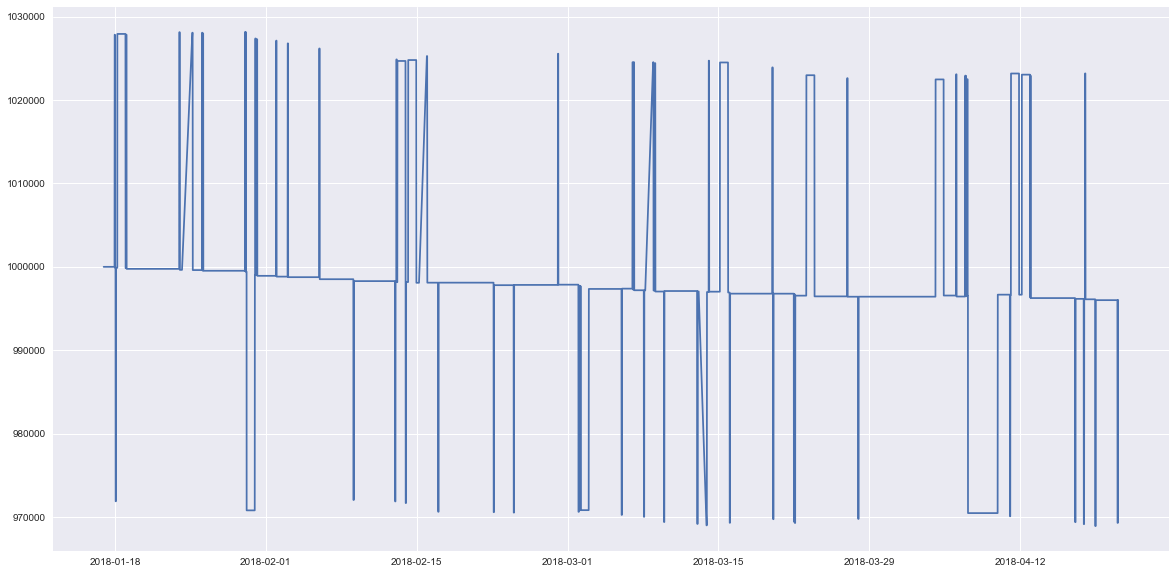

In [39]:
plt.figure()
plt.figure(figsize=(20,10))
plt.plot(positions['cash'])
plt.show()